In [1]:
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
push!(LOAD_PATH, photochemistry_source_dir)

5-element Vector{String}:
 "/home/emc/GDrive-CU/Research-Modeling/UpperAtmoDH/Code/"
 "@"
 "@v#.#"
 "@stdlib"
 "/home/emc/OneDrive-CU/Research/Venus/Code/Photochemistry/src/"

In [11]:
using Photochemistry  # custom module
using Revise
using Photochemistry: T, plot_temp_prof, Keddy, scaleH_lowerboundary

In [3]:
include("CONSTANTS.jl")

Dict{Symbol, Float64} with 4 entries:
  :H  => 4.0e-15
  :D  => 4.5e-15
  :H2 => 4.5e-15
  :HD => 5.0e-15

In [20]:
Tsurf = 735.
Tmeso = 170. 
Texo = 260.
alt = collect( 0:2e5:250e5);
Tn = [T(z, Tsurf, Tmeso, Texo, "neutral") for z in alt]
Ti = [T(z, Tsurf, Tmeso, Texo, "ion") for z in alt]
Te = [T(z, Tsurf, Tmeso, Texo, "electron") for z in alt];

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


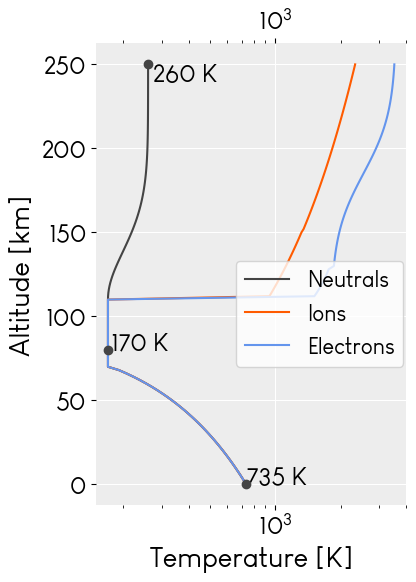

In [5]:
plot_temp_prof(Tn; Tprof_2=Ti, Tprof_3=Te, showonly=true, xl2=4000, alt)

In [14]:
Keddy([58e5], [8.51e18])

1-element Vector{Float64}:
 39032.41188169693

In [6]:
zmin = 58e5

T_bottom = T(zmin, 735., 170., 260., "neutral")

270.99999999999994

In [22]:
scaleH_lowerboundary(zmin, T_bottom; molmass)

584911.4274052415

In [23]:
a = zeros(10)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

# Ion temps from Fox and SUng 2001

In [15]:
using DelimitedFiles
using Interpolations

In [26]:
function T_new(z::Float64, Tsurf::Float64, Tmeso::Float64, Texo::Float64, sptype::String; lapserate=-8e-5)
    #= 
    Input:
        z: altitude above surface in cm
        Tsurf: Surface temperature in KT
        Tmeso: tropopause/mesosphere tempearture
        Texo: exobase temperature
        sptype: "neutral", "ion" or "electron". NECESSARY!
    Output: 
        A single temperature value in K.
    
    Uses the typical temperature structure for neutrals, but interpolates temperatures
    for ions and electrons above 108 km according to the profiles in Fox & Sung 2001.
    =#
    
    # Subroutines
    function T_upper_atmo_neutrals(zee)
        return Texo - (Texo - Tmeso)*exp(-((zee - z_meso_top)^2)/(8e10*Texo))
    end
    
    function upperatmo_i_or_e(z, particle_type; Ti_array=Ti_interped, Te_array=Te_interped, select_alts=new_a)
        #=
        Finds the index for altitude z within new_a
        =#
        i = something(findfirst(isequal(z), select_alts), 0)
        returnme = Dict("electron"=>Te_array[i], "ion"=>Ti_array[i])
        return returnme[particle_type]
    end

    # Load profiles from Fox&Sung 2001. 
    Tion = readdlm("./Resources/PlotsFromPapers/foxandsung2001_Tion.dat",' ', Float64, comments=true, comment_char='#')
    Telec = readdlm("./Resources/PlotsFromPapers/foxandsung2001_Te.dat",' ', Float64, comments=true, comment_char='#')

    T_i = Tion[:, 1]
    T_e = Telec[:, 1]
    
    alt_i = Tion[:, 2] .* 1e5
    alt_e = Telec[:, 2] .* 1e5
    
    interp_ion = LinearInterpolation(alt_i, T_i)
    interp_elec = LinearInterpolation(alt_e, T_e)
    
    new_a = collect(108e5:2e5:250e5)
    Ti_interped = [interp_ion(a) for a in new_a];
    Te_interped = [interp_elec(a) for a in new_a];
    
    # Define mesosphere scope.
    z_meso_bottom = alt[searchsortednearest(alt, (Tmeso-Tsurf)/(lapserate))]
    z_meso_top = 110e5  # height of the tropopause top
    
    
    # In the lower atmosphere, neutrals, ions, and electrons all have the same temperatures. 
    if z < z_meso_bottom
        return Tsurf + lapserate*z
    elseif z_meso_bottom <= z <= z_meso_top 
        return Tmeso
    # Near the top of the isothermal mesosphere, profiles diverge.        
    elseif z > z_meso_top
        if sptype=="neutral"
            return T_upper_atmo_neutrals(z)
        else
            return upperatmo_i_or_e(z, sptype)
        end
    end
end

T_new (generic function with 2 methods)

In [22]:
Tn_test = [T_new(z, Tsurf, Tmeso, Texo, "neutral") for z in alt]
Ti_test = [T_new(z, Tsurf, Tmeso, Texo, "ion") for z in alt]
Te_test = [T_new(z, Tsurf, Tmeso, Texo, "electron") for z in alt];

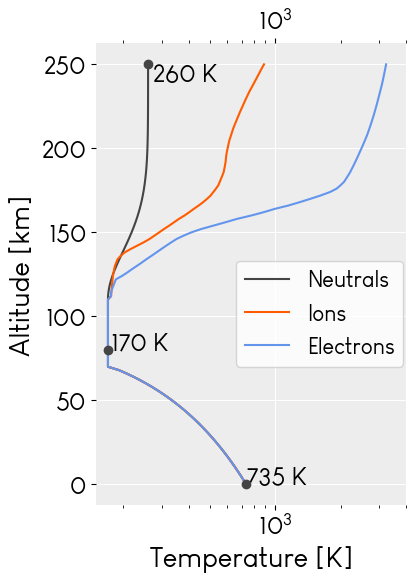

In [25]:
plot_temp_prof(Tn_test; Tprof_2=Ti_test, Tprof_3=Te_test, showonly=true, xl2=4000, alt)